Goal: augment our tracking CNN model with a likelihood-based objective and per-event estimates of uncertainties

Author: Dustin Anderson

In [129]:
# Standard imports
import sys

# Package imports
import numpy as np
np.random.seed(2341)

import matplotlib.pyplot as plt
%matplotlib inline

from keras import models, layers
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

# Local imports
sys.path.append("/home/duanders/AI-HEP.Trk/discrete_extraps")
from drawing import draw_event, draw_input_and_pred

I'm going to keep the number of pixels roughly the same, but change the detector shape so it has fewer layers and more pixels per layer.

In [130]:
# Training parameters
batch_size = 256
epoch_size = 256000
num_epochs = 30

# Data parameters
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)

# Track slopes are chosen by choosing a start and end point at random,
# where the end point lies on a plane some distance away (possibly behind the detector)
eff_depth = det_width

# Scale track slopes up so that slopes and intercepts receive equal weights in the loss function.
slope_scale = eff_depth/2

# Number of tracks in each event follows Poisson distribution
mean_tracks = 3
max_tracks = 6

In [131]:
def simulate_straight_track(m, b, det_shape):
    """
    Simulate detector data for one straight track.
    Parameters:
        m: track slope parameter
        b: track first-layer intercept parameter (detector entry point)
        det_shape: tuple of detector shape: (depth, width)
    Returns:
        ndarray of binary detector data for one track.
    """
    x = np.zeros(det_shape)
    idx = np.arange(det_shape[0])
    hits = (idx*m + b).astype(int)
    valid = (hits > 0) & (hits < det_shape[1])
    x[idx[valid], hits[valid]] = 1
    return x

# Generator for single-track events
def gen_tracks(batch_size=batch_size, det_shape=det_shape):
    """Arguments: 
         batch_size: number of events to yield for each call
       Yields: batches of training data for use with the keras fit_generator function
    """
    while True:
        # Entry and exit points are randomized
        bs = np.random.random_sample(size=batch_size)*det_width
        b2s = np.random.random_sample(size=batch_size)*det_width
        # Note: slopes are calculated assuming a square detector.
        # This prevents extremely large slope values in the non-square detector case
        ms = (b2s-bs)/eff_depth*slope_scale # scaled slope
        tracks = np.zeros((batch_size, 1, det_depth, det_width))
        # append dummy values for covariance matrix entries
        # (these are predicted by the model but have no ground truth values)
        dummy_cov = np.zeros((batch_size))
        targets = zip(bs, ms, dummy_cov, dummy_cov, dummy_cov)
        for i, (b,m,_,_,_) in enumerate(targets):
            tracks[i,0] = simulate_straight_track(m/slope_scale, b, det_shape)
        targets = np.asarray(targets)
        yield tracks, targets
        
# Generator for multi-track events.
# Each event contains exactly n_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_n_tracks(batch_size=batch_size, det_shape=det_shape, n_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=n_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, n_tracks, 5))
        for n in range(batch_size):
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks ), 0, 1)
            event_targets = np.asarray(targets)
            batch_targets[n] = event_targets[event_targets[:,0].argsort()] # sort by first column
        yield batch_events, batch_targets
        
# Generator for multi-track events.
# Each event contains up to max_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_multi_tracks(batch_size=batch_size, det_shape=det_shape, mean_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=max_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, max_tracks, 5))
        for n in range(batch_size):
            num_tracks = min( max_tracks, np.random.poisson(mean_tracks) )
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
            event_targets = np.asarray(targets[:num_tracks])
            batch_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column
        yield batch_events, batch_targets

[[ 25.57873616   8.36826908   0.           0.           0.        ]
 [ 35.58380225 -17.19540698   0.           0.           0.        ]
 [ -1.          -1.          -1.          -1.          -1.        ]
 [ -1.          -1.          -1.          -1.          -1.        ]
 [ -1.          -1.          -1.          -1.          -1.        ]
 [ -1.          -1.          -1.          -1.          -1.        ]]


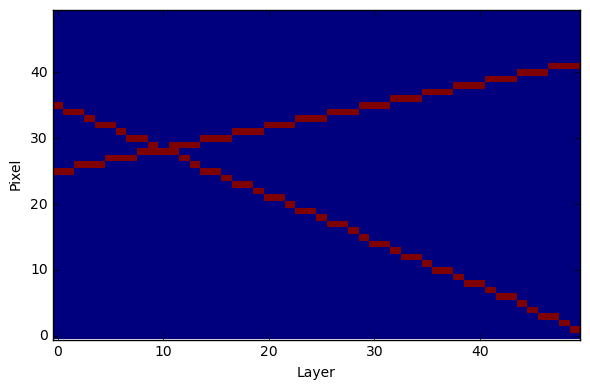

In [4]:
# Test the multi-track generator
tracks, targets = gen_multi_tracks().next()
draw_event(tracks[0,0])
print targets[0]

### Likelihood-based objective function

The goal now is to define a model that makes predictions about its uncertainties event by event and track by track.  

The model will have a second output for each track: the independent entries of the track parameter covariance matrix.  This output will be learned jointly with the track parameters.  The loss function will be a gaussian likelihood for the track parameters, using the covariance matrix output by the model.

In [132]:
import gauss_likelihood_loss

# Model
def build_model_2(n_tracks=mean_tracks):
    """Same architecture as model 1, but also outputs track covariance matrix"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(n_tracks)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    output_layer_tracks = layers.TimeDistributed(layers.Dense(2))(layer) # track parameters
    layer_cov = layers.TimeDistributed(layers.Dense(3))(layer) # track covariance matrix parameters
    output_layer_cov = layers.Lambda(gauss_likelihood_loss.covariance_from_network_outputs)(layer_cov)
    output_layer = layers.merge([output_layer_tracks, output_layer_cov], mode='concat', concat_axis=2)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss=gauss_likelihood_loss.gauss_likelihood_loss_2D, optimizer='Adam')
    return model

In [133]:
import theano as th
import theano.tensor as T
from gauss_likelihood_loss import covariance_from_network_params, covariance_matrix_2D

in_params = T.vector()
out_params = covariance_matrix_2D( in_params )
covariance = th.function(inputs=[in_params], outputs=out_params)

def simulate_track_from_cov_matrix(track_params, cov_params, ntoys=1000):
    """Given the covariance matrix parameters, generate random track slope/intercept
        from the covariance matrix and draw the resulting track"""
    cov = covariance(cov_params)
    event = np.zeros(det_shape)
    toys = np.random.multivariate_normal(mean=track_params, cov=cov, size=ntoys)
    for i in range(ntoys):
        b, m = toys[i]
        event += simulate_straight_track(m/slope_scale, b, det_shape)
    return event

def simulate_event_from_cov_matrix(event_pred, ntoys=1000):
    return sum( [ simulate_track_from_cov_matrix(track_params=pred[:2], cov_params=pred[2:])
                       for pred in event_pred ] )

def make_pred_with_errors(model, n_tracks=mean_tracks):
    """Returns a 2D array representing the model output, with the envelope of possible values drawn in"""
    test_data = gen_n_tracks(n_tracks=n_tracks).next()
    test_event = test_data[0][0]
    test_target = test_data[1][0]
    test_pred = model.predict(np.asarray([test_event]))[0]
    print test_target
    print test_pred
    pred_event = simulate_event_from_cov_matrix(test_pred, ntoys=10000)
    draw_input_and_pred(test_event[0], pred_event)
    
    #central_pred_event = np.clip(sum([ simulate_straight_track(line[1]/slope_scale, line[0], det_shape) for line in test_pred ]), 0, 1)
    #draw_input_and_pred(test_event[0], central_pred_event)

How about we break off a second part of the network and use it to predict the covariance matrix.

In [16]:
# Model
def build_model_3(n_tracks=mean_tracks):
    """Use a separate LSTM and dense layer for the covariance matrix part"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    
    layer_tracks = layers.Dense(400)(layer)
    layer_tracks = layers.RepeatVector(n_tracks)(layer_tracks)
    layer_tracks = layers.LSTM(400, return_sequences=True)(layer_tracks)
    output_layer_tracks = layers.TimeDistributed(layers.Dense(2))(layer_tracks) # track parameters
    
    layer_cov = layers.Dense(400)(layer)
    layer_cov = layers.RepeatVector(n_tracks)(layer_cov)
    layer_cov = layers.LSTM(400, return_sequences=True)(layer_cov)
    layer_cov = layers.TimeDistributed(layers.Dense(3))(layer_cov) # track covariance matrix parameters
    output_layer_cov = layers.Lambda(gauss_likelihood_loss.covariance_from_network_outputs)(layer_cov)
    
    output_layer = layers.merge([output_layer_tracks, output_layer_cov], mode='concat', concat_axis=2)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss=gauss_likelihood_loss.gauss_likelihood_loss_2D, optimizer='Adam')
    return model

In [10]:
# Train the model
model_3 = build_model_3(n_tracks=1)
train_generator = gen_n_tracks(n_tracks=1)
model_3.fit_generator(train_generator, epoch_size, 5)

Epoch 1/5
256000/256000 [==============================] - 864s - loss: 1048.8457   
Epoch 2/5
256000/256000 [==============================] - 863s - loss: -1072.2773   
Epoch 3/5
256000/256000 [==============================] - 874s - loss: -1452.6158   
Epoch 4/5
256000/256000 [==============================] - 876s - loss: -1734.0187   
Epoch 5/5
256000/256000 [==============================] - 874s - loss: -1885.9351   


In [50]:
train_generator = gen_n_tracks(n_tracks=1)
model_3.fit_generator(train_generator, epoch_size, 1)

Epoch 1/1
256000/256000 [==============================] - 1147s - loss: -2194.8626  


[[ 44.97612829 -13.50120791   0.           0.           0.        ]]
[[ 44.46386337 -13.13781834   0.46085787  -0.28790388   0.18191282]]


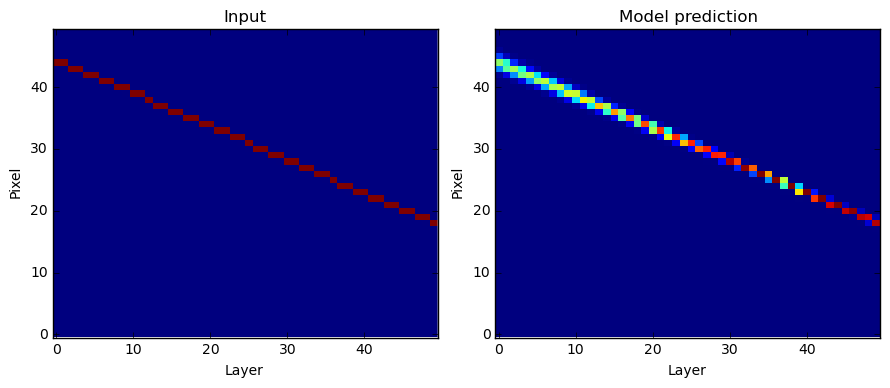

In [48]:
make_pred_with_errors(model_3, n_tracks=1)

It appears to work!

In [16]:
# Model
def build_model_4(n_tracks=mean_tracks):
    """Model 3, but with more convolutional layers and batch normalization"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(128, 3, 3, border_mode='same')(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(128, 3, 3, border_mode='same')(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    
    layer_tracks = layers.Dense(400)(layer)
    layer_tracks = layers.RepeatVector(n_tracks)(layer_tracks)
    layer_tracks = layers.LSTM(400, return_sequences=True)(layer_tracks)
    output_layer_tracks = layers.TimeDistributed(layers.Dense(2))(layer_tracks) # track parameters
    
    layer_cov = layers.Dense(400)(layer)
    layer_cov = layers.RepeatVector(n_tracks)(layer_cov)
    layer_cov = layers.LSTM(400, return_sequences=True)(layer_cov)
    layer_cov = layers.TimeDistributed(layers.Dense(3))(layer_cov) # track covariance matrix parameters
    output_layer_cov = layers.Lambda(gauss_likelihood_loss.covariance_from_network_outputs)(layer_cov)
    
    output_layer = layers.merge([output_layer_tracks, output_layer_cov], mode='concat', concat_axis=2)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss=gauss_likelihood_loss.gauss_likelihood_loss_2D, optimizer='Adam')
    return model

In [18]:
# Train the model

model_3_twotracks = build_model_3(n_tracks=2)
train_generator = gen_n_tracks(n_tracks=2)
model_3_twotracks.fit_generator(train_generator, epoch_size, 10)

Epoch 1/10
256000/256000 [==============================] - 1193s - loss: 3192.2022  
Epoch 2/10
256000/256000 [==============================] - 1180s - loss: -1659.9836  
Epoch 3/10
256000/256000 [==============================] - 1185s - loss: -2424.6790  
Epoch 4/10
256000/256000 [==============================] - 1174s - loss: -2712.8813  
Epoch 5/10
256000/256000 [==============================] - 1174s - loss: -3009.1703  
Epoch 6/10
256000/256000 [==============================] - 1176s - loss: -3155.7014  
Epoch 7/10
256000/256000 [==============================] - 1190s - loss: -3152.7073  
Epoch 8/10
256000/256000 [==============================] - 1193s - loss: -3382.3809  
Epoch 9/10
256000/256000 [==============================] - 1191s - loss: -3403.0768  
Epoch 10/10
256000/256000 [==============================] - 1188s - loss: -3523.3940  


[[  0.79192589  10.37813348   0.           0.           0.        ]
 [  1.75309962  23.30862972   0.           0.           0.        ]]
[[  0.78974962  10.51503181   0.03792436  -0.14571087   4.29490757]
 [  2.14537811  23.20101357   0.03087227  -0.05101836   2.4303441 ]]


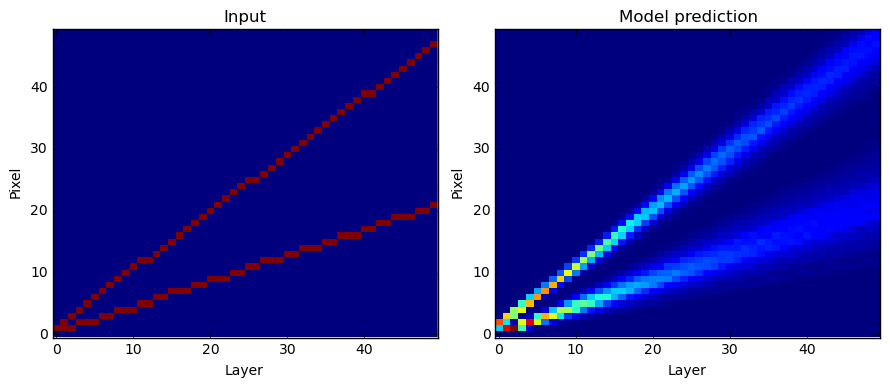

In [46]:
make_pred_with_errors(model_3_twotracks, n_tracks=2)

In [29]:
model_3_fourtracks = build_model_3(n_tracks=4)
train_generator = gen_n_tracks(n_tracks=4)
model_3_fourtracks.fit_generator(train_generator, epoch_size, 10)

Epoch 1/10
256000/256000 [==============================] - 2098s - loss: 9714.4725  
Epoch 2/10
256000/256000 [==============================] - 2095s - loss: 1309.4586  
Epoch 3/10
256000/256000 [==============================] - 2086s - loss: -1291.0682  
Epoch 4/10
256000/256000 [==============================] - 2088s - loss: -2196.6610  
Epoch 5/10
256000/256000 [==============================] - 2090s - loss: -2771.5232  
Epoch 6/10
256000/256000 [==============================] - 2100s - loss: -3063.9161  
Epoch 7/10
256000/256000 [==============================] - 2086s - loss: -3406.1331  
Epoch 8/10
256000/256000 [==============================] - 2097s - loss: -3622.3490  
Epoch 9/10
256000/256000 [==============================] - 2097s - loss: -3438.3020  
Epoch 10/10
256000/256000 [==============================] - 2086s - loss: -3917.8124  


[[ 12.17108827   3.30227885   0.           0.           0.        ]
 [ 26.95104868   8.64398149   0.           0.           0.        ]
 [ 44.56443508  -8.11565491   0.           0.           0.        ]
 [ 49.02162332 -21.52797153   0.           0.           0.        ]]
[[  1.21259699e+01   3.26917744e+00   8.44122190e-03  -8.53993371e-03
    2.32182834e-02]
 [  2.71125565e+01   8.35209846e+00   7.70181837e-03  -1.06427539e-02
    4.98184077e-02]
 [  4.45553818e+01  -8.12338829e+00   1.79682467e-02  -2.85508707e-02
    1.15064442e-01]
 [  4.90917625e+01  -2.15099087e+01   1.17893768e-02  -1.29425023e-02
    3.84603143e-02]]


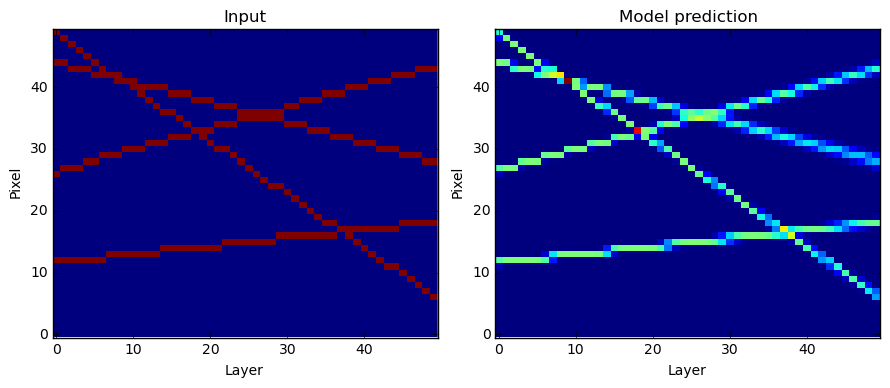

In [35]:
make_pred_with_errors(model_3_fourtracks, n_tracks=4)

### Checking the sanity of the uncertainties

The likelihood model assumes that the track parameters are distributed as a multivariate normal.  It's important to check that the covariance matrices learned by the network actually correspond with its performance.  

For a 2-dimensional gaussian random variable with a fixed mean and covariance matrix, the square of the Mahalanobis distance (i.e. (x-mu)^T Sigma (x-mu), where mu and sigma are the mean and covariance matrix respectively) is distributed as a chi-square with 2 degrees of freedom.  Let's use this property to check the sanity of the uncertainties.  It's the analogue in 2D of checking that the pull distribution is normal.

In [93]:
model_3.save("model_3_singletrack.hdf5")

In [134]:
import scipy.stats as stats
import pylab
import numpy.linalg

def squared_mahalanobis_distance(true, pred, cov):
    resid = (pred-true)
    return np.dot( np.transpose(resid), np.dot( np.linalg.inv(cov), resid ) )

def cov_from_params(params):
    """turns vector [variance1, covariance, variance2] into 2x2 covariance matrix"""
    return np.stack( [params, np.roll(params, shift=-1)] )[:,:2]

def sim_mahalanobis_distribution(model, ntoys=100):
    """Generates random events and computes the Mahalanobis distance for each.  
        Returns the list of all sampled M. distance values."""
    gen = gen_n_tracks(n_tracks=1)
    m = [] # simulated values of M. distance
    for _ in range(ntoys):
        test_data = gen.next()
        test_event = test_data[0][0]
        true = test_data[1][0,0,:2]
        test_pred = model.predict(np.asarray([test_event]))[0]
        pred = test_pred[0,:2]
        cov = cov_from_params( test_pred[0,2:] )
        m.append(squared_mahalanobis_distance(true, pred, cov))
    return m

def make_qq_plot(mahalanobis_vals):
    ref = range(0,15)
    stats.probplot(mahalanobis_vals, dist=stats.chi2, sparams=(2,), fit=False, plot=plt)
    plt.axis([0,10,0,10])
    plt.plot(ref, ref, 'k--')
    plt.show()

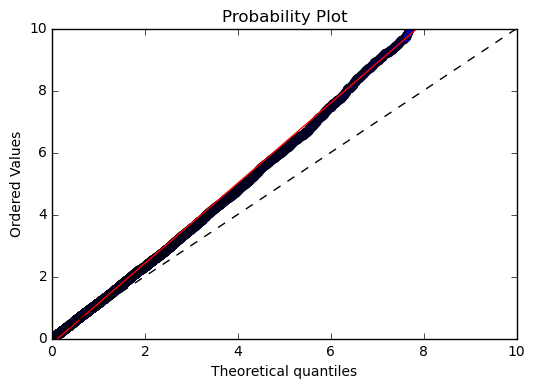

In [125]:
make_qq_plot( sim_mahalanobis_distribution(model_3, ntoys=10000) )

The probability plot shows visually how the quantiles of our sample distribution map onto the quantiles of the chi squared distribution.  

This plot indicates that the shape of the distribution of pulls is correct, but the scale is slightly off.  (experimentation indicates that scaling down the model residuals by about 10% makes the uncertainties match the true performance)

In [126]:
model_3_sixtracks = build_model_3(n_tracks=6)
train_generator = gen_n_tracks(n_tracks=6)
model_3_sixtracks.fit_generator(train_generator, epoch_size, 10)

Epoch 1/10
256000/256000 [==============================] - 3048s - loss: 12865.4693  
Epoch 2/10
256000/256000 [==============================] - 3037s - loss: 4046.9029  
Epoch 3/10
256000/256000 [==============================] - 3041s - loss: 824.7954  
Epoch 4/10
256000/256000 [==============================] - 3046s - loss: -574.8315  
Epoch 5/10
256000/256000 [==============================] - 3043s - loss: -1419.2217  
Epoch 6/10
256000/256000 [==============================] - 3038s - loss: -1617.9796  
Epoch 7/10
256000/256000 [==============================] - 3039s - loss: 5690.3544  
Epoch 8/10
256000/256000 [==============================] - 3042s - loss: 16211.2234  
Epoch 9/10
256000/256000 [==============================] - 3038s - loss: 14875.2907  
Epoch 10/10
256000/256000 [==============================] - 3060s - loss: 10150.8359  


[[  1.0721145    0.89462306   0.           0.           0.        ]
 [  6.80314648   9.62342595   0.           0.           0.        ]
 [ 10.65248015  11.23562773   0.           0.           0.        ]
 [ 20.5459627   -2.73754353   0.           0.           0.        ]
 [ 21.20836573  -0.88350841   0.           0.           0.        ]
 [ 41.53862137   1.21660236   0.           0.           0.        ]]
[[  0.91993707   1.87806404   1.30998468  -1.86335886   8.65617466]
 [  5.58464909   9.72764111   1.13072014  -1.79155469  15.00325298]
 [ 10.92615414   9.1947794    1.11237669  -1.77220833  16.4639473 ]
 [ 19.14370155   1.95676708   1.11606276  -1.78211141  16.78730392]
 [ 22.91352463  -1.00541139   1.12264574  -1.79647946  16.94070244]
 [ 40.6434288   -2.52268934   1.12959254  -1.81142366  17.07022667]]


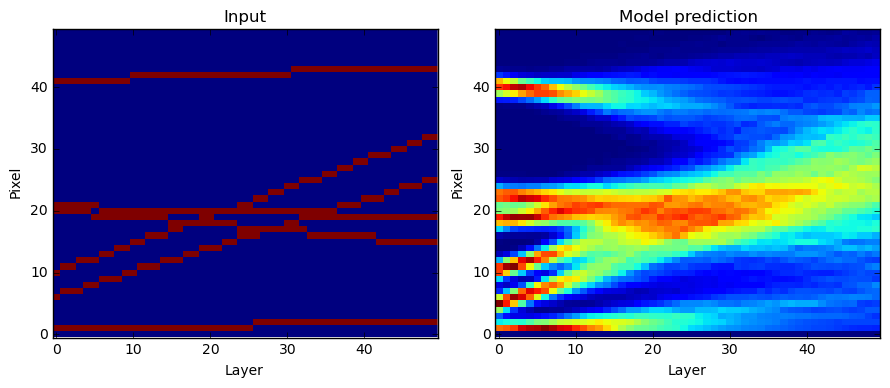

In [128]:
make_pred_with_errors(model_3_sixtracks, n_tracks=6)

The training seems unstable for larger numbers of tracks.  One idea for making it more stable is to make the two branches of the network talk to each other -- the branch that predicts the track parameters should give its output to the branch that predicts the covariance.

In [135]:
# Model
def build_model_5(n_tracks=mean_tracks):
    """Use a separate LSTM and dense layer for the covariance matrix part"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    
    layer_tracks = layers.Dense(400)(layer)
    layer_tracks = layers.RepeatVector(n_tracks)(layer_tracks)
    layer_tracks = layers.LSTM(400, return_sequences=True)(layer_tracks)
    output_layer_tracks = layers.TimeDistributed(layers.Dense(2))(layer_tracks) # track parameters
    
    layer_cov = layers.Dense(400)(layer)
    layer_cov = layers.RepeatVector(n_tracks)(layer_cov)
    layer_cov = layers.merge([layer_cov, output_layer_tracks], mode='concat', concat_axis=2)
    layer_cov = layers.LSTM(400, return_sequences=True)(layer_cov)
    layer_cov = layers.TimeDistributed(layers.Dense(3))(layer_cov) # track covariance matrix parameters
    output_layer_cov = layers.Lambda(gauss_likelihood_loss.covariance_from_network_outputs)(layer_cov)
    
    output_layer = layers.merge([output_layer_tracks, output_layer_cov], mode='concat', concat_axis=2)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss=gauss_likelihood_loss.gauss_likelihood_loss_2D, optimizer='Adam')
    return model

In [136]:
model_5_4 = build_model_5(n_tracks=4)
train_generator = gen_n_tracks(n_tracks=4)
model_5_4.fit_generator(train_generator, epoch_size, 10)

WARNING (theano.gof.cmodule): Removing key file /home/duanders/.theano/compiledir_Linux-3.19--generic-x86_64-with-Ubuntu-15.04-vivid-x86_64-2.7.9-64/tmpIFpJR1/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /home/duanders/.theano/compiledir_Linux-3.19--generic-x86_64-with-Ubuntu-15.04-vivid-x86_64-2.7.9-64/tmpcbwqlj/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /home/duanders/.theano/compiledir_Linux-3.19--generic-x86_64-with-Ubuntu-15.04-vivid-x86_64-2.7.9-64/tmppLL4Sz/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /home/duanders/.theano/compiledir_Linux-3.19--generic-x86_64-with-Ubuntu-15.04-vivid-x86_64-2.7.9-64/tmpEx0KsY/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /home/duanders/.theano/compiledi

Epoch 1/10
256000/256000 [==============================] - 2235s - loss: 8800.5923  
Epoch 2/10
256000/256000 [==============================] - 2238s - loss: 332.6384  
Epoch 3/10
256000/256000 [==============================] - 2237s - loss: -1767.7426  
Epoch 4/10
256000/256000 [==============================] - 2242s - loss: -2612.4678  
Epoch 5/10
256000/256000 [==============================] - 2237s - loss: -3074.0191  
Epoch 6/10
256000/256000 [==============================] - 2248s - loss: -3484.4773  
Epoch 7/10
256000/256000 [==============================] - 2306s - loss: -3033.7664  
Epoch 8/10
256000/256000 [==============================] - 2240s - loss: -3865.1690  
Epoch 9/10
256000/256000 [==============================] - 2233s - loss: -4100.3768  
Epoch 10/10
256000/256000 [==============================] - 2245s - loss: -4206.6243  


[[  8.78856546   6.90373029   0.           0.           0.        ]
 [ 30.47193586   3.86224908   0.           0.           0.        ]
 [ 47.18301059  -2.09589074   0.           0.           0.        ]
 [ 48.48023262 -11.58544419   0.           0.           0.        ]]
[[  8.78244114e+00   6.69734907e+00   8.11213907e-03  -7.35580362e-03
    2.10141223e-02]
 [  3.04270267e+01   3.56647205e+00   1.47773279e-02  -1.85862966e-02
    8.97592530e-02]
 [  4.72389679e+01  -2.20411563e+00   3.07878666e-02  -3.02452520e-02
    1.34234339e-01]
 [  4.85368843e+01  -1.18511105e+01   1.98838357e-02  -1.59143768e-02
    6.94817379e-02]]


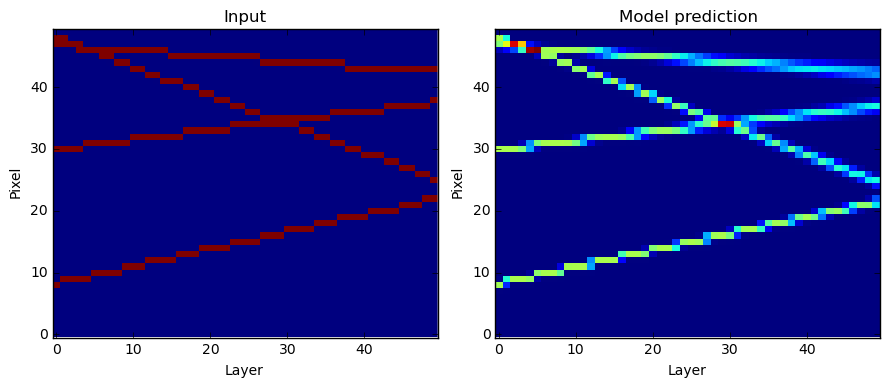

In [141]:
make_pred_with_errors(model_5_4, n_tracks=4)

In [142]:
model_5_6 = build_model_5(n_tracks=6)
train_generator = gen_n_tracks(n_tracks=6)
model_5_6.fit_generator(train_generator, epoch_size, 10)

Epoch 1/10
256000/256000 [==============================] - 3312s - loss: 16654.2734  
Epoch 2/10
256000/256000 [==============================] - 3312s - loss: 6012.7575  
Epoch 3/10
256000/256000 [==============================] - 3320s - loss: 1474.8210  
Epoch 4/10
256000/256000 [==============================] - 3308s - loss: -357.2624  
Epoch 5/10
256000/256000 [==============================] - 3317s - loss: 214.2985  
Epoch 6/10
256000/256000 [==============================] - 3307s - loss: -1099.9008  
Epoch 7/10
256000/256000 [==============================] - 3313s - loss: -2101.6433  
Epoch 8/10
256000/256000 [==============================] - 3314s - loss: -2700.8210  
Epoch 9/10
256000/256000 [==============================] - 3311s - loss: 1275.0274  
Epoch 10/10
256000/256000 [==============================] - 3302s - loss: 1319.1199  


[[  1.36974594  15.75775167   0.           0.           0.        ]
 [  6.69020236  21.63831197   0.           0.           0.        ]
 [ 23.13099704  10.61460022   0.           0.           0.        ]
 [ 30.07537097  -9.60023389   0.           0.           0.        ]
 [ 38.62709968  -5.03073719   0.           0.           0.        ]
 [ 46.07520399 -17.31577709   0.           0.           0.        ]]
[[  1.41710794e+00   1.58946314e+01   1.37379998e-02  -1.42378630e-02
    8.16761702e-02]
 [  6.94472837e+00   2.07193089e+01   2.06383616e-02  -3.14566866e-02
    2.05920428e-01]
 [  2.30048332e+01   1.04783545e+01   3.34627964e-02  -5.93722127e-02
    4.82638150e-01]
 [  3.02417088e+01  -1.06161556e+01   3.81339826e-02  -5.92680983e-02
    3.77384067e-01]
 [  3.85209503e+01  -4.45838690e+00   4.25684191e-02  -7.10345581e-02
    5.42939126e-01]
 [  4.59840469e+01  -1.75100803e+01   2.96637714e-02  -3.66621539e-02
    1.78565845e-01]]


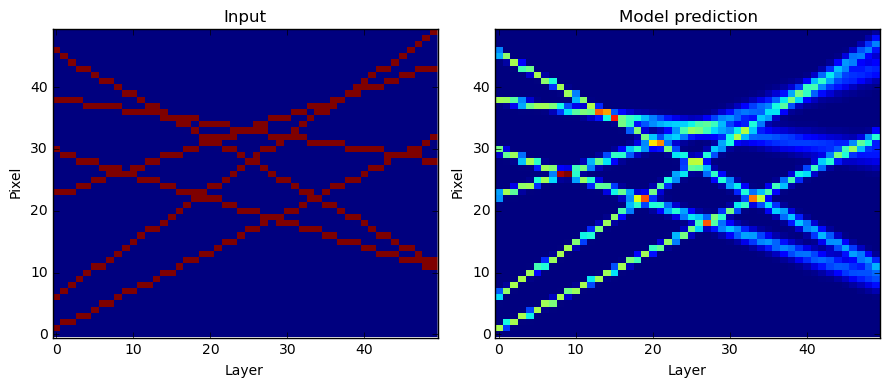

In [154]:
make_pred_with_errors(model_5_6, n_tracks=6)

[[ 10.73800872  11.73122492   0.           0.           0.        ]
 [ 16.63287489   2.47765778   0.           0.           0.        ]
 [ 23.78129657   8.69033237   0.           0.           0.        ]
 [ 28.52443446   9.29361963   0.           0.           0.        ]
 [ 39.01676671 -13.50255085   0.           0.           0.        ]
 [ 41.83986601   1.32901974   0.           0.           0.        ]]
[[  1.07840490e+01   1.14283895e+01   1.38452435e-02  -1.47264386e-02
    7.54626915e-02]
 [  1.65479507e+01   1.94613135e+00   2.85531059e-02  -4.67215292e-02
    4.14232522e-01]
 [  2.40377388e+01   9.40406895e+00   2.70177443e-02  -4.26701643e-02
    3.71104568e-01]
 [  2.87294140e+01   7.44291639e+00   4.09407802e-02  -7.19434619e-02
    5.44476628e-01]
 [  3.93452225e+01  -1.38276644e+01   3.74981165e-02  -5.53058498e-02
    3.58853966e-01]
 [  4.18622818e+01   1.93616951e+00   4.36832570e-02  -5.93304001e-02
    4.20706183e-01]]


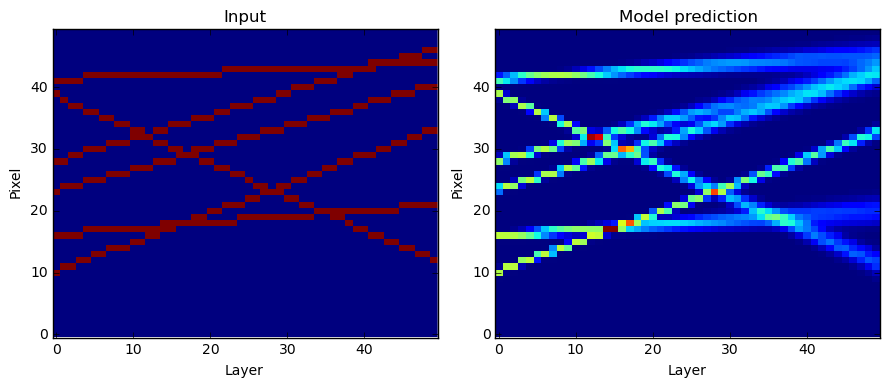

In [159]:
make_pred_with_errors(model_5_6, n_tracks=6)

In [160]:
train_generator = gen_n_tracks(n_tracks=6)
model_5_6.fit_generator(train_generator, epoch_size, 10)

Epoch 1/10
256000/256000 [==============================] - 3335s - loss: -608.2487  
Epoch 2/10
256000/256000 [==============================] - 3319s - loss: -1188.8332  
Epoch 3/10
256000/256000 [==============================] - 3320s - loss: -2239.2607  
Epoch 4/10
256000/256000 [==============================] - 3365s - loss: -3011.5173  
Epoch 5/10
256000/256000 [==============================] - 3392s - loss: 1174.4878  
Epoch 6/10
256000/256000 [==============================] - 3359s - loss: 7671.7315  
Epoch 7/10
256000/256000 [==============================] - 3350s - loss: 5377.2457  
Epoch 8/10
256000/256000 [==============================] - 3347s - loss: 3297.8431  
Epoch 9/10
256000/256000 [==============================] - 3347s - loss: 3280.5623  
Epoch 10/10
256000/256000 [==============================] - 3335s - loss: 4892.1844  


[[  3.19082625e+00   1.06126362e+01   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.17841386e+01   1.50371134e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.57222803e+01   1.96732326e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.91503056e+01  -2.32419754e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.99297495e+01   9.30592818e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.75888608e+01   5.21367012e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]]
[[  3.660743    10.91931534   0.9593246   -0.286879     3.88841677]
 [ 11.43330765  -1.54333472   1.02027905  -0.76977313   6.45395708]
 [ 25.46128654  -0.44244331   1.06945539  -0.898516     6.18983793]
 [ 29.20277596  -2.54255605   1.11355805  -0.94167978   5.50721788]
 [ 30.33678818   9.05581951   0.99481583  -0.83736604   8.11039257]
 [ 37.96393204   5.44066811   1.01975536  -0.86628175   7.43158913]]


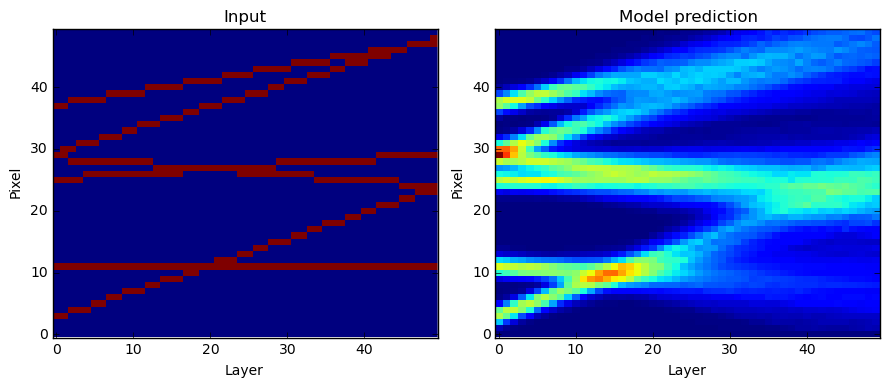

In [163]:
make_pred_with_errors(model_5_6, n_tracks=6)

During training the loss function oscillates.  Hypothesis: if the model weights take a wrong turn during training, the track-finding part of the network gets worse, which forces the covariance-finding part of the network to report larger variances.  So small fluctuations towards worse model performance can grow out of control.

Solution: pre-train the track-finding part of the network.  